### Домашнее задание

#### Задание 1.
Самостоятельно разобраться с тем, что такое tfidf (документация

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html 

и еще - 
https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

#### Задание 2.
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. 
Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

#### Задание 3.
Повторить п.2, но используя уже не медиану, а max

<b> Задание 4. </b> (опциональное, если очень хочется)

Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). 
Подсказка 2 - нужен именно idf, как вес.

#### Задание 5.
Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

#### Задание 6.
Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Ссылки
http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

Библиотеки, которые нужно установить:

gensim

razdel

pymorphy2

nltk

<b>Дано три датасета:</b>

1) Новости: id и текст самой новости;

2) Список новостей, которые прочел пользователь: uid и список id статей, которые он прочел;

3) Информация об оттоке: uid, churn;

In [1]:
import pandas as pd

Загружаем датасет с новостями (1)

In [2]:
news = pd.read_csv("/Users/Adm1n/ml_for_business/Lesson2/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим датасет с пользователями и списками последних прочитанных новостей

In [3]:
users = pd.read_csv("/Users/Adm1n/ml_for_business/Lesson2/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Загрузим данные по оттоку клиентов - таргет

In [4]:
target = pd.read_csv("/Users/Adm1n/ml_for_business/Lesson2/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


Нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

In [5]:
pip install gensim


  Using cached gensim-4.1.2-cp38-cp38-win_amd64.whl (24.0 MB)
  Using cached Cython-0.29.23-cp38-cp38-win_amd64.whl (1.7 MB)
  Using cached smart_open-5.2.1-py3-none-any.whl (58 kB)
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21



In [6]:
pip install razdel


Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install pymorphy2


  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13709 sha256=311fe6159a57a7bd2ec974c54fad07fe113eefb613de3c51729f325585098b32
  Stored in directory: c:\users\adm1n\appdata\local\pip\cache\wheels\56\ea\58\ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


### 1. Получаем векторные представления новостей

In [5]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [6]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adm1n\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# загрузим стоп слова русского языка
stopword_ru = stopwords.words('russian')
len(stopword_ru)

# Создаем морфологический анализатор (позволяет привести слова с разными окончаниями к общей форме)
morph = pymorphy2.MorphAnalyzer()

In [8]:
# добавим к стоп-словам еще один список из нашего дополнительного файла

with open('/Users/Adm1n/ml_for_business/Lesson2/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-9-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 28.9 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 59s


А теперь в 3 строчки обучим нашу модель

In [12]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [13]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
# создаем словарь из всех встречающихся в датасете слов
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts] #формируем bag of words



Запускаем обучение

In [14]:
from gensim.models import LdaModel

In [15]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=20, id2word=common_dictionary)#, passes=10)

Wall time: 38.3 s


In [16]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель.

как выглядят наши темы?

как получить для документа вектор значений (вероятности принадлежности каждой теме)?

In [17]:
# Create a new corpus, made of previously unseen documents.
# сформируем новый мешок слов из документов, которые ранее не были задействованы

other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(16, 0.52232414), (17, 0.07079372), (18, 0.22681856), (19, 0.16224284)]

In [18]:
x=lda.show_topics(num_topics=20, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: фестиваль германия лекарство европа мероприятие альянс армения коллекция латвия эстония
topic_1: женщина мужчина эксперимент пенсия тело вода управление агентство nn земля
topic_2: это год который банк компания правительство вопрос решение также россия
topic_3: температура градус билет виза знаменитый образоваться сектор диапазон дневный выручка
topic_4: газ суд дело сотрудник взрыв полиция уголовный nn задержать убийство
topic_5: россия российский президент страна гражданин это путин глава заявить санкция
topic_6: смерть век британский великобритания авария умереть мэй скончаться пережить французский
topic_7: это мочь который ребёнок nn россия банк система случай весь
topic_8: год рубль млрд млн москва который составить область около статья
topic_9: украина военный украинский россия метод киев космонавт дыра это сведение
topic_10: рост египет зарплата бизнесмен треть год увеличение двигатель млн плата
topic_11: рейтинг мышь полоса место список млн ii взорваться занять самый
t

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [19]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(20):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [20]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(20)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(20)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.0,0.796209,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.014200,0.00000,0.000000,0.037509,0.080331,0.064891
1,4896,0.0,0.0,0.000000,0.0,0.707635,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.269857
2,4897,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.522352,0.070762,0.226814,0.162251
3,4898,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.451347,0.0,0.080015,0.00000,0.365214,0.000000,0.000000,0.093962
4,4899,0.0,0.0,0.616500,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.23424,0.000000,0.000000,0.058927,0.068056


Мы получили вектора наших новостей и умеем интерпретировать получившиеся темы.


### Следующий шаг - векторные представления пользователей

In [21]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [22]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(20)]].values))

In [23]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.32956171, 0.        , 0.15531056, 0.04827573, 0.        ,
       0.017984  , 0.        , 0.1572917 , 0.        , 0.        ,
       0.        , 0.14277065, 0.13893487, 0.        , 0.        ])

In [24]:
user_articles_list = users['articles'].iloc[33]

# Функция для получения вектора пользователя по темам прочитанных статей
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [25]:
get_user_embedding(user_articles_list)

array([0.        , 0.02803942, 0.117363  , 0.        , 0.11633518,
       0.19050296, 0.        , 0.15275753, 0.00303291, 0.03207432,
       0.        , 0.        , 0.0958663 , 0.        , 0.01358212,
       0.        , 0.22130789, 0.        , 0.00493099, 0.01113347])

In [26]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [27]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(20)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(20)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.0,0.013377,0.020847,0.0,0.039095,0.143914,0.000000,0.144330,0.063356,...,0.012223,0.0,0.072885,0.0,0.055051,0.010238,0.222346,0.040240,0.114923,0.000000
1,u108690,0.0,0.006668,0.097732,0.0,0.078450,0.166647,0.002278,0.151006,0.046826,...,0.010847,0.0,0.072480,0.0,0.004022,0.000000,0.267226,0.007107,0.025700,0.000000
2,u108339,0.0,0.064448,0.117941,0.0,0.130324,0.113521,0.002012,0.076887,0.159203,...,0.000000,0.0,0.062736,0.0,0.010929,0.000000,0.186518,0.006498,0.024463,0.013171


In [28]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.0,0.013377,0.020847,0.0,0.039095,0.143914,0.000000,0.144330,0.063356,...,0.0,0.072885,0.0,0.055051,0.010238,0.222346,0.040240,0.114923,0.000000,0
1,u108690,0.0,0.006668,0.097732,0.0,0.078450,0.166647,0.002278,0.151006,0.046826,...,0.0,0.072480,0.0,0.004022,0.000000,0.267226,0.007107,0.025700,0.000000,1
2,u108339,0.0,0.064448,0.117941,0.0,0.130324,0.113521,0.002012,0.076887,0.159203,...,0.0,0.062736,0.0,0.010929,0.000000,0.186518,0.006498,0.024463,0.013171,1


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [30]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(20)]], 
                                                    X['churn'], random_state=0)

In [31]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [32]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.16730989, 0.12310384, 0.38906752, 0.20357599, 0.0492975 ,
       0.06475226, 0.10845774, 0.04820853, 0.15160493, 0.19539269])

In [33]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score¶

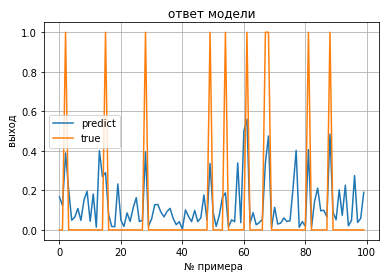

In [34]:
plt.plot( preds[:100], label = 'predict')
plt.plot(y_test.values[:100], label = 'true')
plt.title('ответ модели')
plt.xlabel(' № примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

По графику видно, что threshold должен быть существенно ниже 0.5. Получим его лучшее значение ниже:

In [35]:
precision, recall, thresholds = precision_recall_curve(y_test.values[:1000], preds[:1000])

fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix_ = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix_], 
                                                                        fscore[ix_],
                                                                        precision[ix_],
                                                                        recall[ix_]))

Best Threshold=0.301952, F-Score=0.687, Precision=0.731, Recall=0.648


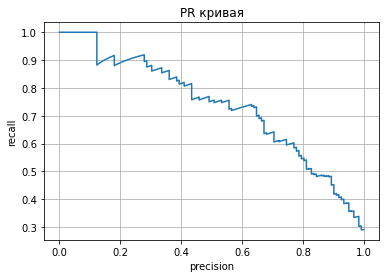

In [36]:
plt.plot(recall,precision )
plt.title('PR кривая')
plt.xlabel('precision')
plt.ylabel('recall')
plt.grid('On')
plt.show()

In [37]:
import itertools

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1679   76]
 [  91  154]]


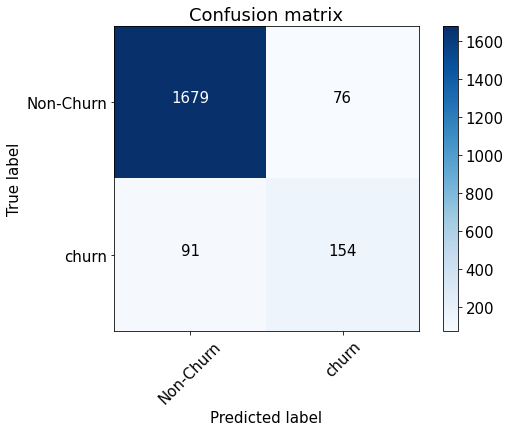

In [39]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix_])
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [40]:
roc_auc_score_ = roc_auc_score(y_test, preds)
roc_auc_score_

0.9340775626489913

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу.

#### Задание 2.

Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [41]:
# Функция для получения вектора пользователя по темам прочитанных статей с использованием медианы
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector1 = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector1 = np.median(user_vector1, 0)
    return user_vector1

In [42]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(20)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(20)]]

X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.0,0.000000,0.000000,0.0,0.000000,0.138020,0.0,0.126108,0.030525,...,0.0,0.052372,0.0,0.000000,0.0,0.160151,0.0,0.017016,0.000000,0
1,u108690,0.0,0.000000,0.097118,0.0,0.019733,0.106803,0.0,0.131955,0.016769,...,0.0,0.073645,0.0,0.000000,0.0,0.233729,0.0,0.012626,0.000000,1
2,u108339,0.0,0.044534,0.122372,0.0,0.138406,0.070870,0.0,0.084635,0.135165,...,0.0,0.058668,0.0,0.008415,0.0,0.203411,0.0,0.028201,0.008441,1


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(20)]], 
                                                    X['churn'], random_state=0)


In [44]:
logreg = LogisticRegression(C=1.0)
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]

In [45]:
precision1, recall1, thresholds1 = precision_recall_curve(y_test.values[:1000], preds[:1000])

fscore1 = (2 * precision1 * recall1) / (precision1 + recall1)

# locate the index of the largest f score
ix1 = np.argmax(fscore1)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds1[ix1], 
                                                                        fscore1[ix1],
                                                                        precision1[ix1],
                                                                        recall1[ix1]))

Best Threshold=0.267119, F-Score=0.770, Precision=0.713, Recall=0.836


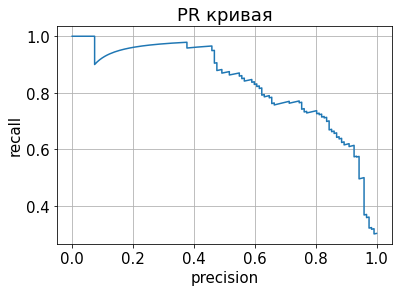

In [46]:
plt.plot(recall1,precision1 )
plt.title('PR кривая')
plt.xlabel('precision')
plt.ylabel('recall')
plt.grid('On')
plt.show()

Confusion matrix, without normalization
[[1716   39]
 [ 102  143]]


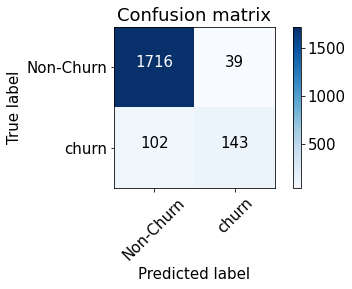

In [47]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds1[ix_])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [48]:
roc_auc_score1 = roc_auc_score(y_test, preds)
roc_auc_score1

0.9614652014652015

#### Задание 3

Повторить п.2, но используя уже не медиану, а max

In [49]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector1 = np.max(user_vector, 0)  
    return user_vector1

In [50]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(20)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(20)]]

X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.0,0.045677,0.109952,0.0,0.234573,0.329562,0.000000,0.391735,0.222840,...,0.0,0.175273,0.0,0.289835,0.061429,0.548668,0.138935,0.456920,0.000000,0
1,u108690,0.0,0.040007,0.193721,0.0,0.346874,0.410181,0.013667,0.229701,0.133297,...,0.0,0.132516,0.0,0.024131,0.000000,0.482066,0.028600,0.101058,0.000000,1
2,u108339,0.0,0.217985,0.230755,0.0,0.226088,0.292055,0.012074,0.119495,0.422421,...,0.0,0.137120,0.0,0.026529,0.000000,0.229952,0.038988,0.054764,0.036362,1


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(20)]], 
                                                    X['churn'], random_state=0)

In [52]:
precision2, recall2, thresholds2 = precision_recall_curve(y_test.values[:1000], preds[:1000])

fscore2 = (2 * precision2 * recall2) / (precision2 + recall2)

# locate the index of the largest f score
ix2 = np.argmax(fscore2)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds2[ix2], 
                                                                        fscore2[ix2],
                                                                        precision2[ix2],
                                                                        recall2[ix2]))


Best Threshold=0.267119, F-Score=0.770, Precision=0.713, Recall=0.836


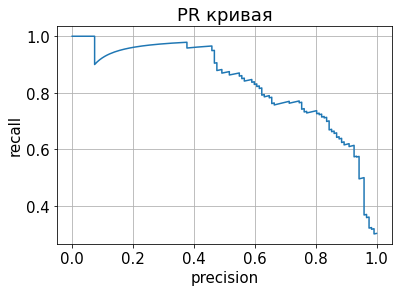

In [53]:
plt.plot(recall2,precision2 )
plt.title('PR кривая')
plt.xlabel('precision')
plt.ylabel('recall')
plt.grid('On')
plt.show()

Confusion matrix, without normalization
[[1716   39]
 [ 102  143]]


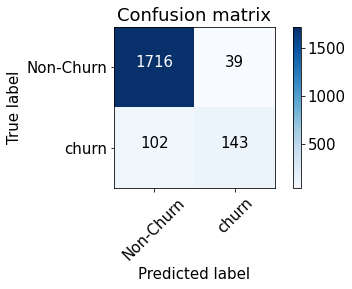

In [54]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds1[ix_])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [55]:
roc_auc_score2 = roc_auc_score(y_test, preds)
roc_auc_score2

0.9614652014652015

#### Задание 5

Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [56]:
evaluation = pd.DataFrame({
    'тип усреднения': ['mean', 'median', 'max'],
    'precision': [precision[ix_], precision1[ix1], precision2[ix2]],
    'recall': [recall[ix_], recall1[ix1], recall2[ix2]],
    'F score': [fscore[ix_], fscore1[ix1], fscore2[ix2]],
    'ROC-AUC score': [roc_auc_score_, roc_auc_score1, roc_auc_score2],
})

evaluation

,тип усреднения,precision,recall,F score,ROC-AUC score
0,mean,0.731481,0.647541,0.686957,0.934078
1,median,0.713287,0.836066,0.769811,0.961465
2,max,0.713287,0.836066,0.769811,0.961465


#### Задание 6

Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Высокие значения метрик достигаются при разбиении на 20 тем и при использовании максимального значения среди вероятностей каждой темы при формировании вектора пользователя. 
Очевидно, что выбор максимального значения среди вероятностей тематик - наиболее удачный.
Если мы выбираем среднее, то сильно падают показатели полноты (recall) и f-меры, то есть падает качество классификации - мы менее точно предсказываем количество покинувших портал пользователей, частично их пропуская.
